# Lab 2: Studying anomalous rainfall

#### Learning Goals

This lab works through some "typical" climatology statistics and comparisons to observations. 

Our goals are:
1. Get you comfortable using Xarray API for computation.
2. Get you comfortable using Xarray's plotting capabilities for quickly examining high-dimensional data
3. Understand that Xarray's high-level API (e.g. groupby, resample) allow for expressive computation.

In [ ]:
%config InlineBackend.figure_format = 'retina'

import arraylake as al
import numpy as np
import xarray as xr
import zarr

%xmode minimal

client = al.Client()

np.set_printoptions(threshold=10, edgeitems=2)
xr.set_options(display_expand_data=False)
# maximize I/O throughput on this machine. See `al repo tune -h` for more
zarr.config.set({"async.concurrency": 128})

In [ ]:
client.login()

We'll read the ERA5 AWS data

In [ ]:
repo = client.get_repo("earthmover-public/era5-surface-aws")
session = repo.readonly_session("main")

We will do some timeseries analysis, so let's open the _temporal_ group

In [ ]:
ds = xr.open_dataset(session.store, group="temporal", engine="zarr")
ds

## Subset to NZ

We will subset the data.

and calculate total precipitation as recommended by https://confluence.ecmwf.int/pages/viewpage.action?pageId=111155324

In [ ]:
# Define a bounding box for New Zealand
NZ_BBOX = {"longitude": slice(160, 180), "latitude": slice(-40, -50)}
subset = ds.sel(NZ_BBOX)
subset

## Quick viz

Next visualize this subset

In [ ]:
subset.cp.sel(time="2009-06-23 10:00").plot(cmap="Blues")
subset.lsp.sel(time="2009-06-23 10:00").plot.contour(levels=7, colors="k")

## Calculate total precip

This cell will load the total precip data in to memory, so it is fast to work with

In [ ]:
%%time

total_precip = subset.cp + subset.lsp

## Let's estimate a monthly climatology

Climatology = "let's take all data for all Januaries and average them"

This is a _GroupBy_ problem.

We take the data, group by the "month" (`"time.month"`), and reduce the groups with the `mean`
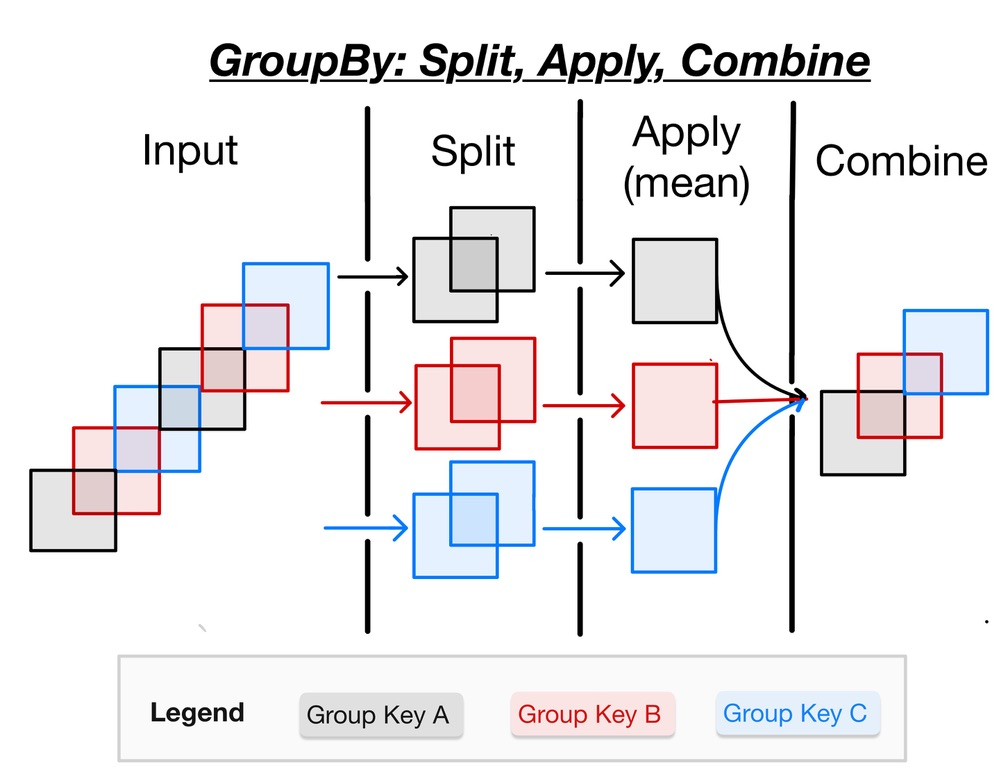

In [ ]:
grouped = total_precip.groupby("time.month")
grouped

The GroupBy object has many methods; `mean` is one:

In [ ]:
clim = grouped.mean()
clim

Let's look at some maps

In [ ]:
clim.plot(col="month", col_wrap=4, cmap="Blues", vmin=0, size=2.5)

### Exercise 1 : plot the monthly mean precip at Wellington

Location: 41°18′S 174°47′E

<details>

    ```python
    wellington = {"latitude": -41 + 18 / 60, "longitude": 174 + 47 / 60}
    # apparently snow is "exceptionally rare"
    clim.total_precip.sel(wellington, method="nearest").plot()
    ```
</details>

### Exercise 2: Repeat the above for Mt. Hutt 

Latitude: -43.471667°, Longitude: 171.526444°

<details>
    
    ```python
    hutt = {"latitude": -43.471667, "longitude": 171.526444}
    subset.total_precip.sel(hutt, method="nearest").plot()
    ```
    
</details>

## Estimate anomalies relative to monthly mean

Xarray has fancy syntax for computing group anomalies : subtract the mean field from the GroupBy object

In [ ]:
anom = total_precip.groupby("time.month") - clim
anom


Let's plot the anomalies for Mt. Hutt

In [ ]:
hutt = {"latitude": -43.471667, "longitude": 171.526444}
anom.sel(hutt, method="nearest").plot()

### Resampling to a different frequency

It's useful to smooth that. Let's resample to a monthly frequency. 
1. We use the pandas frequency string "MS" -- "monthly frequency at month-start".
2. We will accumulate the precip using `sum` to get a "surplus" or "deficit" 

In [ ]:
import matplotlib.pyplot as plt

anom.sel(hutt, method="nearest").resample(time="MS").sum().plot.step(size=6, aspect=2)
plt.axhline(0, color="k")

## Exercise: Compare the ERA5 total precip to precip from the Met Station data

1. Use the data at https://app.earthmover.io/earthsciencesnz/met-stations/
2. Pick your favorite location.
3. Plot time series of the monthly surplus/deficit at that location from both ERA5 and the weather station data.

## Bonus Exercise: Compare the ERA5 total precip to precip at _all_ Met Station sites

This is an advanced exercise that will test everything you've seen today. Please don't look at the solution yet ;)

1. Use the _monthly_ accumulated precip in the `monthly/prcp` array at https://app.earthmover.io/earthsciencesnz/met-stations/
2. Construct ERA5 monthly accumulated precip using [`.resample().sum()`](https://docs.xarray.dev/en/stable/generated/xarray.core.resample.DatasetResample.sum.html#xarray.core.resample.DatasetResample.sum).
3. Interpolate the ERA5 data to the station locations using [`Dataset.interp`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.interp.html)
4. Next you will need to get the station data and the ERA5 data on a common time grid. Use [`xr.align`](https://docs.xarray.dev/en/stable/generated/xarray.align.html) for this. Which `join` option works the best?
6. Use [`xr.corr`](https://docs.xarray.dev/en/stable/generated/xarray.corr.html) to calculate a correlation coefficient between the model and obs at _each_ station. You will have to specify the `dim` argument to `corr`.
7. Use [`Dataset.scatter`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.plot.scatter.html) to visualize spatial patterns in the correlation.
   1. You may need to convert a DataArray toa  Dataset using `DataArray.to_dataset(name="corr")`
   2. Do the patterns make sense? Is there something odd?

Remember that at each step, it will help to make a figure or look at the values in the HTML repr to check for oddities.

### Solution

In [ ]:
repo2 = client.get_repo("earthsciencesnz/met-stations")
obs = xr.open_dataset(
    repo2.readonly_session("main").store,
    group="monthly",
    engine="zarr",
    decode_timedelta=False,
)
obs

#### Construct monthly accumulated precip

In [ ]:
accum = total_precip.resample(time="MS").sum()
accum

#### Interpolate to station locations

In [ ]:
atobs = accum.interp(latitude=obs.latitude, longitude=obs.longitude)
atobs

#### Subsample to stations with precip data

In [ ]:
counts = atobs.count("time")
cleaned = atobs.sel(station=counts > 0)
cleaned

#### Align to a common grid

In [ ]:
cleaned_obs, cleaned_model = xr.align(
    obs.prcp, atobs.sel(station=counts > 0), join="inner"
)

#### Calculate correlation coefficient

In [ ]:
corr = xr.corr(cleaned_obs, cleaned_model, dim="time")
corr = corr.to_dataset(name="corr")
corr

#### Viz results

Grab DEM data for context

In [ ]:
repo3 = client.get_repo("earthsciencesnz/copernicus_dem")
dem = (
    xr.open_dataset(
        repo3.readonly_session("main").store,
        group="90m_new_zealand_complete",
        engine="zarr",
    )
    .coarsen(latitude=50, longitude=50)
    .mean()
)

In [ ]:
corr.plot.scatter(x="longitude", y="latitude", hue="corr", cmap="Reds")
dem.elevation.plot.contour(levels=8, colors="k", lw=0.15, zorder=-1)

We need some more context. Let's add number of observations to the viz.

In [ ]:
corr["counts"] = cleaned_obs.count("time")

In [ ]:
corr.plot.scatter(
    x="longitude", y="latitude", hue="corr", cmap="Reds", markersize="counts"
)
dem.elevation.plot.contour(levels=8, colors="k", lw=0.15, zorder=-1)

Notice that many of the high correlation locations have few observations. We probably want to filter those out.

(also the legend is clearly wrong)

In [ ]:
corr = corr.where(corr.counts > 60, drop=True)

In [ ]:
corr.plot.scatter(
    x="longitude", y="latitude", hue="corr", cmap="Reds", markersize="counts"
)
dem.elevation.plot.contour(levels=8, colors="k", lw=0.15, zorder=-1)